# Keras ile CNN

---

## Görseldeki hayvanın kedi mi köpek mi olduğunu tahmin etme projesi

---

### Gerekli kütüphanelerin import edilmesi




In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

2022-11-21 04:41:04.877856: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 04:41:05.089944: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-21 04:41:05.771954: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-11-21 04:41:05.772084: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_

### Datanın hazırlanması ve train, test ve validation olarak klasörlere bölünmesi

In [2]:
os.chdir('/home/strawberry/DevCodes/jupyterpython/data/dogs-vs-cats')
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')
    
    for c in random.sample(glob.glob('cat*'),500):
        shutil.move(c, 'train/cat')
    for c in random.sample(glob.glob('dog*'),500):
        shutil.move(c, 'train/dog')    
    for c in random.sample(glob.glob('cat*'),100):
        shutil.move(c, 'valid/cat')
    for c in random.sample(glob.glob('dog*'),100):
        shutil.move(c, 'valid/dog')        
    for c in random.sample(glob.glob('cat*'),50):
        shutil.move(c, 'test/cat')
    for c in random.sample(glob.glob('dog*'),50):
        shutil.move(c, 'test/dog')
os.chdir('../../')        

### Datanın train, test ve validation yollarının tanımlanması

In [3]:
train_path = '/home/strawberry/DevCodes/jupyterpython/data/dogs-vs-cats/train'
valid_path = '/home/strawberry/DevCodes/jupyterpython/data/dogs-vs-cats/valid'
test_path = '/home/strawberry/DevCodes/jupyterpython/data/dogs-vs-cats/test'

### Görsellerin modele uygun hale gelecek şekilde işlem görmesi ve hazırlanması

In [4]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes = ['cat','dog'],batch_size = 10)    
    
valid_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes = ['cat','dog'],batch_size = 10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes = ['cat','dog'],batch_size = 10,shuffle=False)
    

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [5]:
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [6]:
imgs, labels = next(train_batches)

### Görselleri görüntülemek için gerekli fonksiyon

In [7]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1,10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip (images_arr , axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()    
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

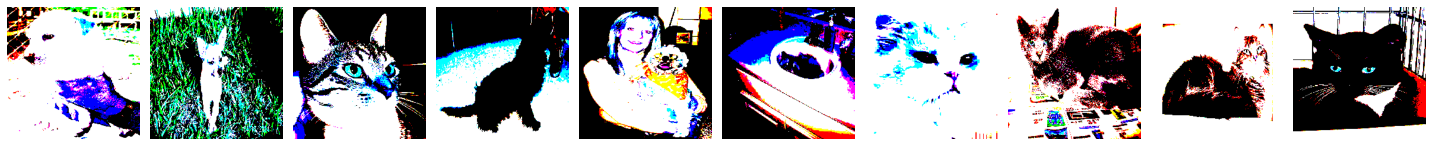

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [8]:
plotImages(imgs)
print(labels)

## Modelin kurulması

In [9]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=2,activation='softmax'),
])

2022-11-21 04:41:07.924013: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2022-11-21 04:41:07.924102: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: strawberry-ABRA-A7-V7-1
2022-11-21 04:41:07.924125: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: strawberry-ABRA-A7-V7-1
2022-11-21 04:41:07.924452: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.85.2
2022-11-21 04:41:07.924531: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-11-21 04:41:07.924551: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 515.65.1 does not match DSO version 510.85.2 -- cannot find working devices in this configuration
2022-11-21 04:41:07.925181: I tensorflow/core/platform/cpu_feature

### Modelin özeti

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 2)                 4

### Modelin compile edilmesi

In [11]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])

### Modelin çalıştırılması

In [12]:
model.fit(x= train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10


2022-11-21 04:41:08.870163: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 64225280 exceeds 10% of free system memory.
2022-11-21 04:41:08.930976: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 16056320 exceeds 10% of free system memory.
2022-11-21 04:41:08.946037: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 32112640 exceeds 10% of free system memory.
2022-11-21 04:41:08.999301: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 16056320 exceeds 10% of free system memory.
2022-11-21 04:41:08.999500: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 32112640 exceeds 10% of free system memory.


100/100 - 40s - loss: 19.6434 - accuracy: 0.5400 - val_loss: 12.1051 - val_accuracy: 0.5050 - 40s/epoch - 396ms/step
Epoch 2/10
100/100 - 41s - loss: 2.2805 - accuracy: 0.7700 - val_loss: 3.7624 - val_accuracy: 0.5950 - 41s/epoch - 410ms/step
Epoch 3/10
100/100 - 41s - loss: 0.8365 - accuracy: 0.8740 - val_loss: 8.3184 - val_accuracy: 0.5250 - 41s/epoch - 405ms/step
Epoch 4/10
100/100 - 41s - loss: 0.6471 - accuracy: 0.8800 - val_loss: 3.5365 - val_accuracy: 0.6150 - 41s/epoch - 406ms/step
Epoch 5/10
100/100 - 45s - loss: 0.0875 - accuracy: 0.9820 - val_loss: 3.9247 - val_accuracy: 0.6100 - 45s/epoch - 450ms/step
Epoch 6/10
100/100 - 56s - loss: 0.0104 - accuracy: 0.9990 - val_loss: 3.6260 - val_accuracy: 0.6050 - 56s/epoch - 560ms/step
Epoch 7/10
100/100 - 44s - loss: 0.0042 - accuracy: 0.9980 - val_loss: 3.4196 - val_accuracy: 0.6450 - 44s/epoch - 443ms/step
Epoch 8/10
100/100 - 45s - loss: 5.7698e-04 - accuracy: 1.0000 - val_loss: 3.4654 - val_accuracy: 0.6450 - 45s/epoch - 445ms/st

## Eğitilen model ile test verisi üzerinde tahmin yapma

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

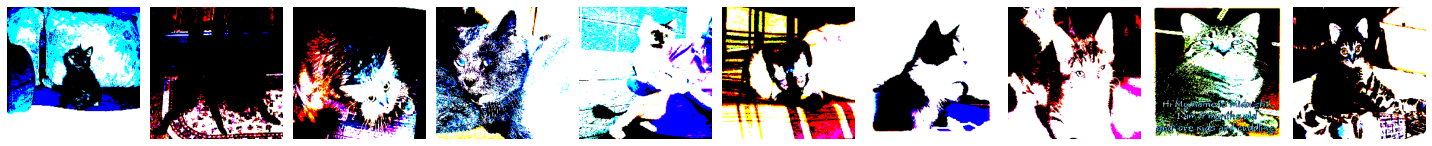

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [13]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [14]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [15]:
predictions= model.predict(x= test_batches, verbose=0)

## Confusion Matrix ile sonuçların grafiğe dökülmesi

In [17]:
cm = confusion_matrix(y_true = test_batches.classes, y_pred = np.argmax(predictions, axis=-1))

In [18]:
def plot_confusion_matrix(cm,classes,
                         normalize=False,
                         title = 'Confusion matrix',
                         cmap = plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range (cm.shape[1])):
        plt.text(j, i , cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()    
    plt.ylabel('Gerçek Sonuç')
    plt.xlabel('Tahmin Edilen Sonuç')
        

In [19]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[33 17]
 [16 34]]


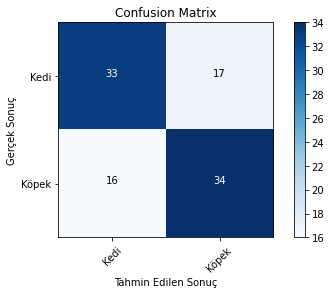

In [20]:
cm_plot_labels = ['Kedi','Köpek']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

## Proje için VGG16 modelin kullanılması

In [21]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

### Modelin Özeti

In [22]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [23]:
type(vgg16_model)

keras.engine.functional.Functional

### VGG-16 Modelinin katmanlarının Sequential modele aktarılması

In [24]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

### Modelin Özeti

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

### Model zaten eğitilmiş bir model olduğu katmanların eğitimini false olarak ayarlanması

In [26]:
for layer in model.layers:
    layer.trainable = False

## Modelin iki çıktısı olduğu için (kedi ve köpek) son katmana 2 unitten oluşan Dense katmanını eklenmesi

In [27]:
model.add(Dense(units=2, activation='softmax'))

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

### Modelin eklenen son katman ile birlikte modelin compile edilmesi ve eğitilmesi



In [29]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [30]:
model.fit(x=train_batches, validation_data = valid_batches, epochs = 5, verbose = 2)

Epoch 1/5
100/100 - 333s - loss: 0.2922 - accuracy: 0.8810 - val_loss: 0.1370 - val_accuracy: 0.9500 - 333s/epoch - 3s/step
Epoch 2/5
100/100 - 305s - loss: 0.1040 - accuracy: 0.9700 - val_loss: 0.1121 - val_accuracy: 0.9450 - 305s/epoch - 3s/step
Epoch 3/5
100/100 - 294s - loss: 0.0786 - accuracy: 0.9760 - val_loss: 0.1043 - val_accuracy: 0.9550 - 294s/epoch - 3s/step
Epoch 4/5
100/100 - 259s - loss: 0.0618 - accuracy: 0.9820 - val_loss: 0.1008 - val_accuracy: 0.9600 - 259s/epoch - 3s/step
Epoch 5/5
100/100 - 251s - loss: 0.0499 - accuracy: 0.9860 - val_loss: 0.1027 - val_accuracy: 0.9650 - 251s/epoch - 3s/step


In [31]:
assert model.history.history.get('accuracy')[-1] > 0.95

##Eğitilen model ile test verisi üzerinde tahmin yapma





In [32]:
predictions = model.predict(x= test_batches, verbose=0)

In [33]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

### Confusion matrix üzerinde sonuçların grafiğe aktarılması

In [34]:
cm = confusion_matrix(y_true = test_batches.classes, y_pred = np.argmax(predictions,axis=-1))

In [35]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[50  0]
 [ 4 46]]


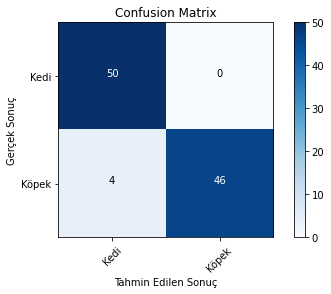

In [36]:
cm_plot_labels = ['Kedi','Köpek']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')